# Libraries

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift

import matplotlib.pyplot as plt

import scipy as sp
from scipy.special import wofz
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import pickle

import os

plt.style.use(['science', 'notebook', 'grid'])

# User-defined functions

In [2]:
def k(wNew):
    part1 = 4*(wNew + 1j*gamma21)*gamma31
    part2 = OmegaC**2 - 4*(wNew + 1j*gamma21)*(wNew + 1j*gamma31)
    return (w0/c)*np.sqrt(1 + ((c*OD)/(w0*L))*part1/part2)


def g(x):
    return np.sqrt(np.pi/8)*(1/x)*wofz(1j/(np.sqrt(8)*x))


def generate_temporal(a=2.13e8, b=7.92e7, c=62):
    detuning = a
    OmegaC = b
    OD = c
    wNew = np.asarray([j + detuning for j in w])
    trans = np.exp(1j*k(wNew)*L)  
    Efr = E0Lfr*trans
    Ef = ifftshift(Efr)
    E = ifft(Ef)    

    # finding element index where probe ignition and extinction occurs
    upIndex = np.min(np.where(t>=tUp))
    downIndex = np.min(np.where(t>=tDown))
    pre_ignition = np.zeros(upIndex)
    pre_ignition_len = len(pre_ignition)
    len_left = N - pre_ignition_len
    output_pulse_len = len(E[0: downIndex])

    if output_pulse_len < len_left:
        part2 = np.flip(np.copy(E[0: downIndex]))
        part2Size = len(part2)
        len_left = N - pre_ignition_len - part2Size
        len_left = -len_left
        part3 = np.flip(np.copy(E[len_left: ]))
        Efinal = np.append(pre_ignition, part2)
        Efinal = np.append(Efinal, part3)
    elif output_pulse_len == len_left:
        part2 = np.flip(np.copy(E[0: downIndex]))
        Efinal = np.append(pre_ignition, part2)  
    elif output_pulse_len > len_left:
        len_left = upIndex + downIndex - N
        part2 = np.flip(np.copy(E[len_left: downIndex]))
        Efinal = np.append(pre_ignition, part2)
    else:
        print("Error!!!")

    return np.abs(Efinal)**2


def generate_spectrum(a, b, c):
    I_s_array = np.array([])
    OmegaC = b
    OD = c

    for i in a:
        detuning = i
        It = generate_temporal(detuning, OmegaC, OD)
        downIndex = np.min(np.where(t>=tDown))
        Is = np.max(It[downIndex: downIndex+200])
        I_s_array = np.append(I_s_array, Is)
        
    return I_s_array

# Constants

In [3]:
# resonant wavelength
lamda0 = 7.95e-7

# resonant wavenumber
k0 = (2*np.pi)/(lamda0)

# speed of light
c = 3e8

# resonant angular frequency
w0 = k0*c

# dephasing rate between |3> and |1>
gamma31 = 1.8850e7

# dephasing rate between |2> and |1>
gamma21 = 0.005*gamma31
gamma21bar = gamma21/gamma31

# physical thickness
L = 0.017

# Resolution for temporal domain
N = 80000   

# total duration of the incident pulse (including both during the zero and non-zero value of the incident intensity)
T = 2.5e-6

# temporal array
t = np.linspace(0, T, N)

# time when pulse is activated
tUp = 0.125e-6

# time when pulse is abruptly switched off
tDown = 2e-6

# incident field
E00 = np.heaviside(t - tUp, 1) - np.heaviside(t - tDown, 1)

# incident field at the edge of the medium's output. acquired a complex phase info
E0L = E00*np.exp(1j*k0*L)

# fft of the pulse above giving out spectrum
E0Lf = fft(E0L)

# rotated/shifted spectrum (for numerical reasons)
E0Lfr = fftshift(E0Lf)  

# frequency domain
f = np.linspace(-N/(2*T), N/(2*T), N)

# angular frequency domain
w = (2.0*np.pi)*f

# Generate temporal

## the arrays

In [4]:
detuning = 11.2*gamma31
OmegaC = 4.2*gamma31
OD = 62
It = generate_temporal(detuning, OmegaC, OD)

## plotting

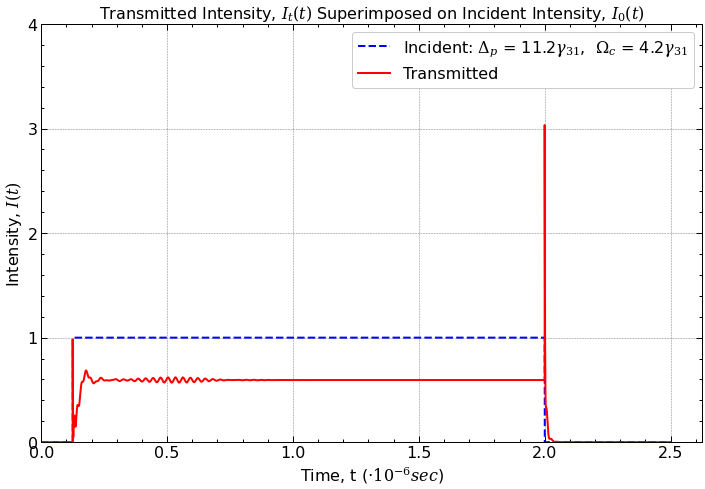

In [5]:
# create figure and axis object
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# plotting output field superimposed on input field at z = L
ax.plot(t*1e6, 
        np.abs(E0L)**2, 
        color="blue", 
        linestyle="dashed", 
        label="Incident: $\Delta_p$ = "+str(detuning/gamma31)+"$\gamma_{31}$"+",  $\Omega_{c}$ = " + str(OmegaC/gamma31) + "$\gamma_{31}$")

ax.plot(t*1e6, 
        It, 
        "r", 
        label="Transmitted")

# title of plot
ax.set_title("Transmitted Intensity, $I_{t}(t)$ Superimposed on Incident Intensity, $I_{0}(t)$")

# axis label
ax.set_xlabel("Time, t ($ \cdot 10^{-6} sec$)")
ax.set_ylabel("Intensity, $I(t)$")

# axis tick
ax.tick_params(axis="x")
ax.tick_params(axis="y")
# ax.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5])
# ax.set_xticks([])
ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0])

# limit on x-axis
ax.set_xlim(0, )

# limit on y-axis
ax.set_ylim(0, 4)

# enable legend
ax.legend()

# adjusting subplots
plt.tight_layout()
plt.show()

# Generate spectrals

## $I_s$ arrays

In [6]:
detuningArray = np.linspace(-100*gamma31, 100*gamma31, 1000)
OmegaC = 4.2*gamma31
OD = 62
# 316
# 337
# 358
# 379
# 400

IsArray = generate_spectrum(detuningArray, OmegaC, OD)

### plotting

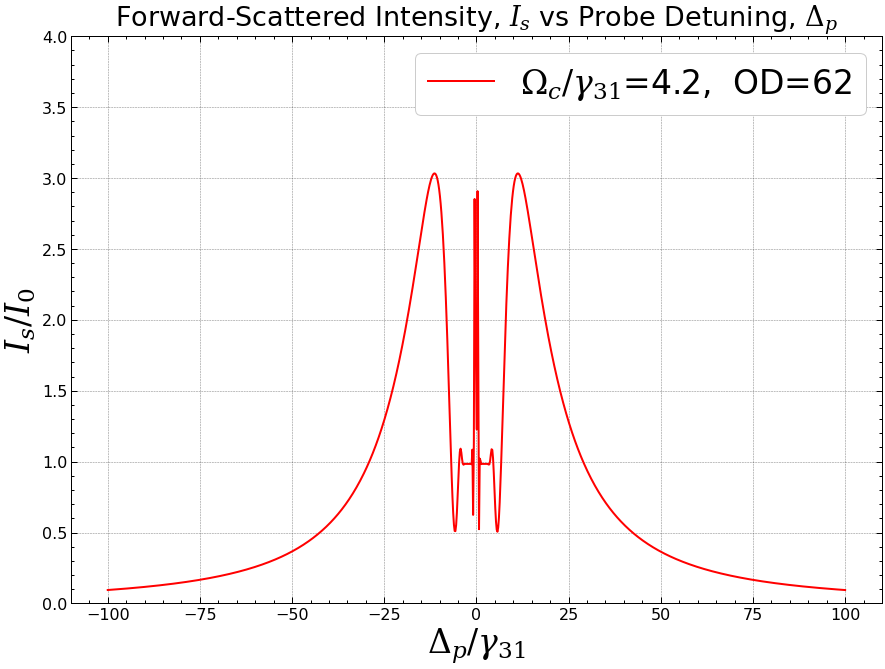

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 9.5))
ax.plot(detuningArray/gamma31, 
        IsArray, 
        color="r", 
        label='$\Omega_{c}/\gamma_{31}$='+str(OmegaC/gamma31)+ ',  OD='+str(OD))
ax.set_ylim(0, 4)
ax.set_title("Forward-Scattered Intensity, $I_{s}$ vs Probe Detuning, $\Delta_p$", fontsize=27)
ax.set_xlabel("$\Delta_{p}/\gamma_{31}$", fontsize=33)
ax.set_ylabel("$I_{s}/I_{0}$", fontsize=33)
ax.legend(fontsize=33)
plt.tight_layout()
plt.show()

## phase shift arrays

In [8]:
phase = np.real(k(detuningArray))*L
phaseShift = phase - k0*L

### plotting

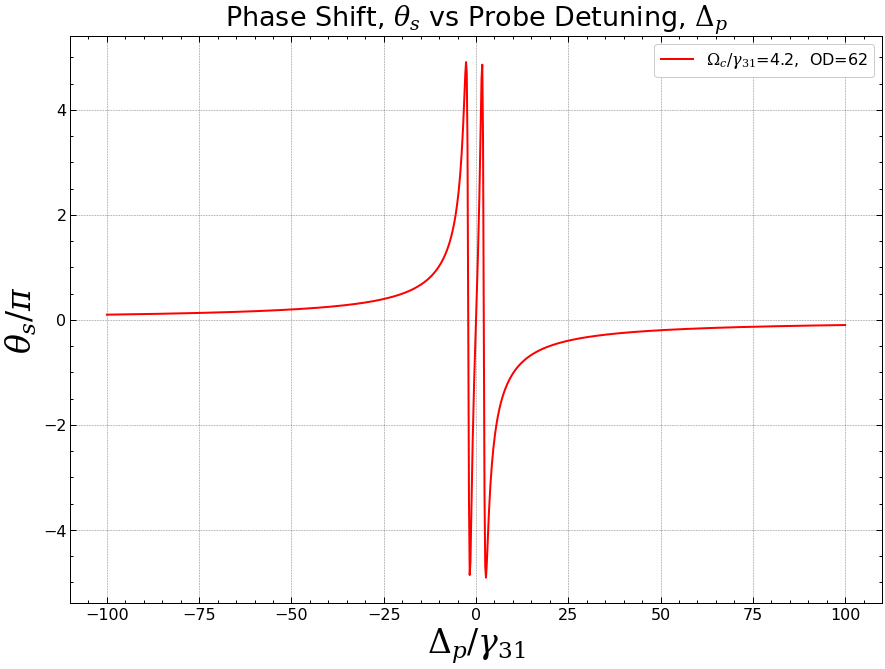

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 9.5))
ax.plot(detuningArray/gamma31, 
        phaseShift/np.pi, 
        color="r", 
        label='$\Omega_{c}/\gamma_{31}$='+str(OmegaC/gamma31)+',  OD='+str(OD))
ax.set_title(r"Phase Shift, $\theta_{s}$ vs Probe Detuning, $\Delta_p$", fontsize=27)
ax.set_xlabel(r"$\Delta_{p}/\gamma_{31}$", fontsize=33)
ax.set_ylabel(r"$\theta_{s}/\pi$", fontsize=33)
ax.legend()
plt.tight_layout()
plt.show()

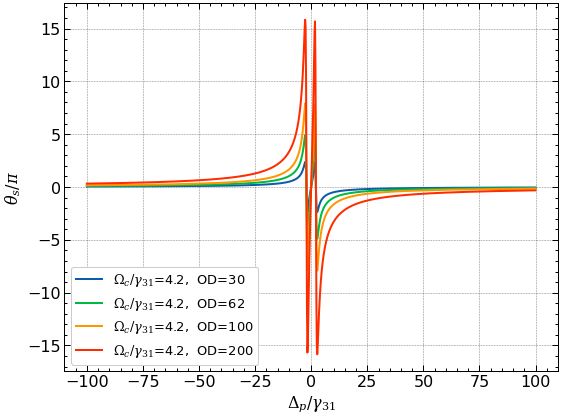

In [10]:
OmegaC = 4.2*gamma31
OD_array = [30, 62, 100, 200]

fig, ax = plt.subplots(1, 1)

for i, value in enumerate(OD_array):
    OD = value
    phase = np.real(k(detuningArray))*L
    phaseShift = phase - k0*L
    ax.plot(detuningArray/gamma31, 
            phaseShift/np.pi, 
            label="$\Omega_{c}/\gamma_{31}$="+str(OmegaC/gamma31)+',  OD='+str(OD))
    ax.set_xlabel(r"$\Delta_p/\gamma_{31}$")
    ax.set_ylabel(r"$\theta_{s}/\pi$")
    ax.legend(loc='lower left', fontsize=13)
    
plt.tight_layout()
plt.show()

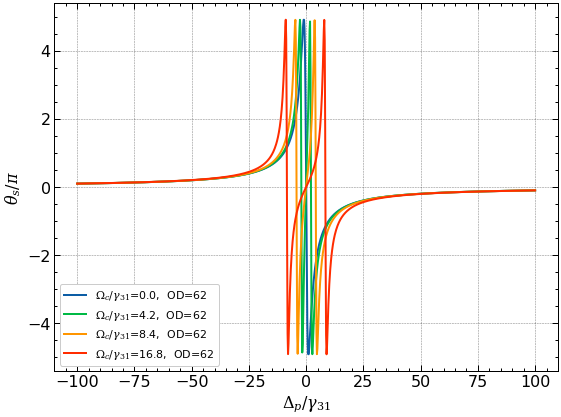

In [11]:
OD = 62
Omega_C_array = [0, 4.2*gamma31, 8.4*gamma31, 16.8*gamma31]

fig, ax = plt.subplots(1, 1)

for i, Omega_C in enumerate(Omega_C_array):
    OmegaC = Omega_C
    phase = np.real(k(detuningArray))*L
    phaseShift = phase - k0*L
    ax.plot(detuningArray/gamma31, 
            phaseShift/np.pi, 
            label="$\Omega_{c}/\gamma_{31}$="+str(OmegaC/gamma31)+',  OD='+str(OD))
    ax.set_xlabel(r"$\Delta_p/\gamma_{31}$")
    ax.set_ylabel(r"$\theta_{s}/\pi$")
    
ax.legend(loc='lower left', fontsize=11)    
plt.tight_layout()
plt.show()

## absorption coefficient arrays

In [10]:
absCoeff = 2*np.imag(k(detuningArray))

### plotting

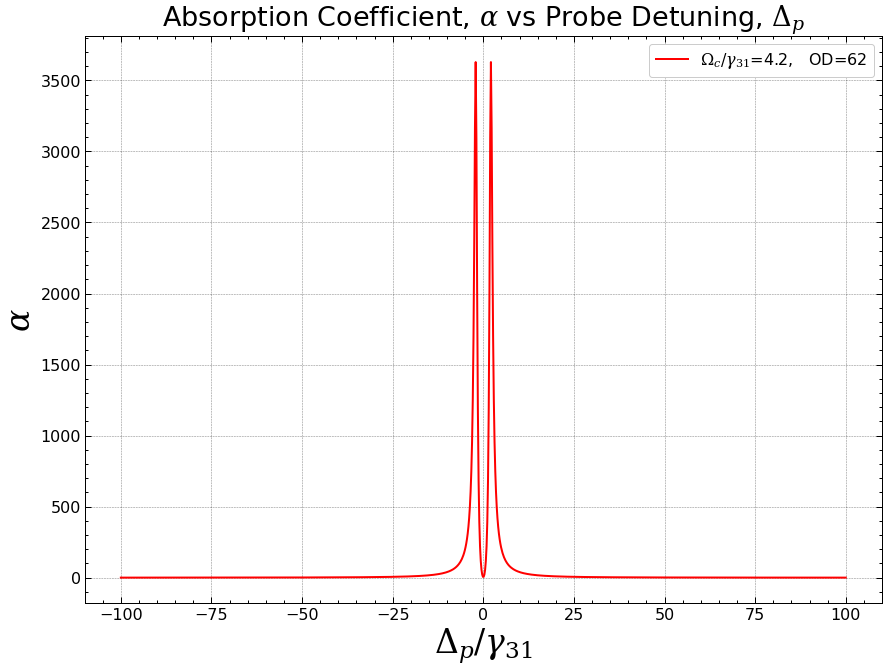

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (12.5, 9.5))
ax.plot(detuningArray/gamma31, 
        absCoeff, 
        color="r", 
        label='$\Omega_{c}/\gamma_{31}$='+str(OmegaC/gamma31)+',   OD='+str(OD))
ax.set_title(r"Absorption Coefficient, $\alpha$ vs Probe Detuning, $\Delta_p$", fontsize= 27)
ax.set_xlabel(r"$\Delta_p/\gamma_{31}$", fontsize = 33)
ax.set_ylabel(r"$\alpha$", fontsize = 33)
ax.legend()
plt.tight_layout()
plt.show()

## steady-state arrays

In [12]:
I = np.exp(-absCoeff*L)

### plotting

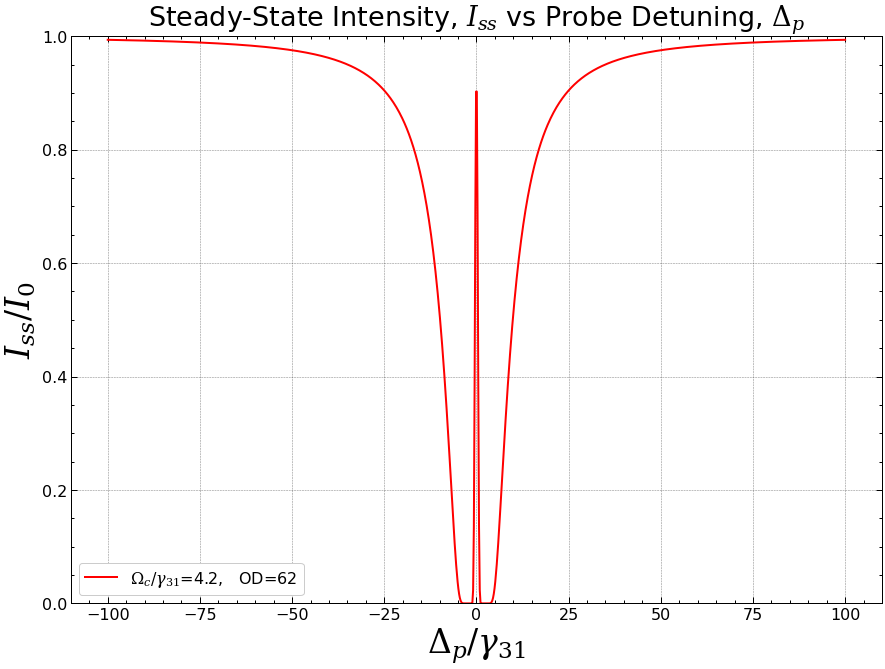

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 9.5))
ax.plot(detuningArray/gamma31, 
        I, 
        color="r", 
        label='$\Omega_{c}/\gamma_{31}$='+str(OmegaC/gamma31)+',   OD='+str(OD))
ax.set_ylim(0, 1)
ax.set_title("Steady-State Intensity, $I_{ss}$ vs Probe Detuning, $\Delta_p$", fontsize= 27)
ax.set_xlabel("$\Delta_p/\gamma_{31}$", fontsize = 33)
ax.set_ylabel("$I_{ss}/I_{0}$", fontsize = 33)
ax.legend()
plt.tight_layout()
plt.show()

# Plotting key plots

## subplot of I_s, phase shift, and steady-state intensity

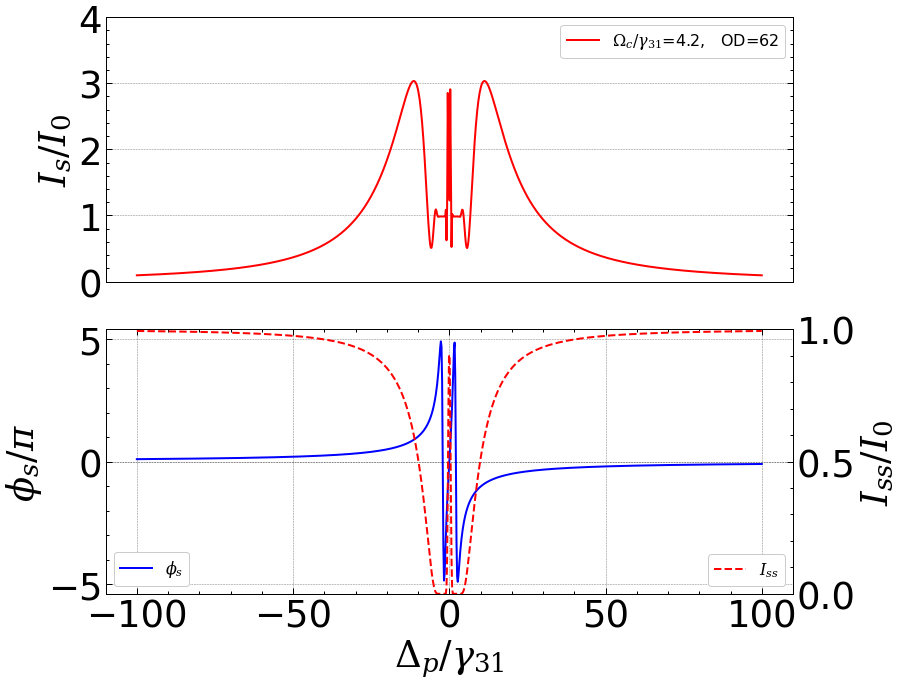

In [14]:
# PLOTTINGS----------------------------------------------------------------
# create figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12.7, 9.7))

# define first axis
ax1 = ax[0]

# define 2nd axis
ax2 = ax[1]

## 1st subplot
# Is spectrum
ax1.plot(detuningArray/gamma31, 
         IsArray, 
         color="r", 
         label='$\Omega_{c}/\gamma_{31}$='+str(OmegaC/gamma31)+',   OD='+str(OD))
    
# set y-limit
ax1.set_ylim(0, 4)

# set axis labels
# ax1.set_xlabel("$\Delta_p/\gamma_{13}$", fontsize=33)
ax1.set_ylabel("$I_{s}/I_{0}$", fontsize=37)

# modify ticks
ax1.set_xticks([])
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.tick_params(axis="x", labelsize=37)
ax1.tick_params(axis="y", labelsize=37)

# legend
# ax1.legend(loc=(0.61, 0.78), fontsize=27)
ax1.legend(loc="upper right")


## 2nd subplot
# phase shift
ax2.plot(detuningArray/gamma31, 
         phaseShift/np.pi, 
         color="b", 
         label="$\phi_s$")

# set axis labels
ax2.set_xlabel("$\Delta_p/\gamma_{31}$", fontsize=37)
ax2.set_ylabel("$\phi_s/\pi$", fontsize=37)

# modify axis ticks
ax2.tick_params(axis="x", labelsize=37)
ax2.tick_params(axis="y", labelsize=37)

# modify ticks
#ax2.set_xticks([-30, -20, -10, 0, 10, 20, 30])
# ax2.set_yticks([-5, -3, -1, 0, 1, 3, 5])

# enable legend
ax2.legend(loc="lower left")

# create 2nd y-axis sharing the same x-axis
ax3 = ax2.twinx()

# steady-state transmission
ax3.plot(detuningArray/gamma31, 
         I, 
         linestyle="dashed",
         color="red", 
         label="$I_{ss}$")

# set axis limit 
ax3.set_ylim(0, 1)

# set axis labels
ax3.set_ylabel("$I_{ss}/I_0$", fontsize=37)

# modify axis ticks
ax3.tick_params(axis="y", labelsize=37)

# enable legend
ax3.legend(loc="lower right")

# plt.subplots_adjust(hspace=0.25)
plt.tight_layout()
plt.show()

## overlay plot of I_S and phase shift

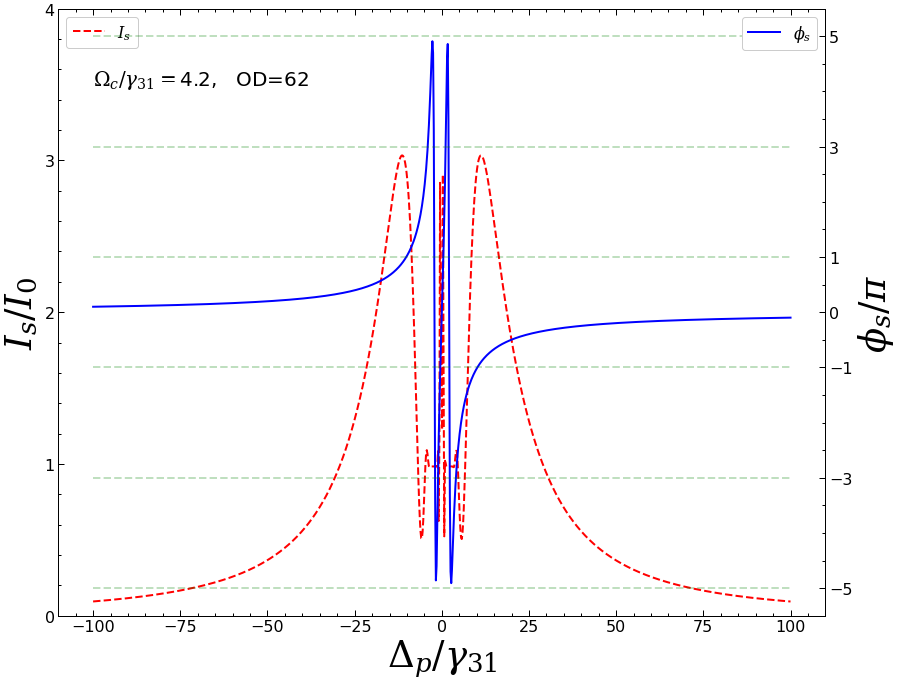

In [15]:
# create figure and axis
fig, ax1 = plt.subplots(1, 1, figsize=(12.7, 9.7))

# twin axis
ax2 = ax1.twinx()

## Is plot
ax1.plot(detuningArray/gamma31, 
         IsArray,
         color='red',
         label='$I_s$',
         linestyle='dashed')
ax1.set_ylim(0, 4)
ax1.set_xlabel("$\Delta_p/\gamma_{31}$", fontsize=37)
ax1.set_ylabel("$I_{s}/I_{0}$", fontsize=37)
ax1.set_yticks([0, 1, 2, 3, 4])
# ax1.tick_params(axis="x", labelsize=37)
# ax1.tick_params(axis="y", labelsize=37)
ax1.legend(loc='upper left')
ax1.grid(False)
ax1.text(x=-100, 
        y=3.5, 
        s='$\Omega_{c}/\gamma_{31}=$'+str(OmegaC/gamma31)+',   OD='+str(OD), 
        rotation=0,
        fontsize=20)

## phase shift plot
ax2.plot(detuningArray/gamma31, 
         phaseShift/np.pi,
         color='blue',
         label="$\phi_s$")
ax2.grid(False)
ax2.legend(loc='upper right')
ax2.set_ylabel("$\phi_s/\pi$", fontsize=37)
ax2.set_yticks([-5, -3, -1, 0, 1, 3, 5])
ax2.hlines(y=[-5, -3, -1, 1, 3, 5], xmin=-100, xmax=100, linestyles='dashed', color='green', alpha=0.25)

# tight_layout and show
plt.tight_layout()
plt.show()

# $\Delta_p$ vs $\Omega_C$ line-surface plot

## arrays ver. 1 (Affine's, not in use)

In [ ]:
OD = 62
N1 = 100
detuningArray = np.linspace(0, 20, N1)*gamma31
N2 = 100
OmegaCArray = np.linspace(0, 20, N2)*gamma31
IsArray = np.zeros((N1, N2))
wNew = np.sum(np.array(np.meshgrid(w, detuningArray)), axis=0)
trans = np.zeros((N2, N1, N), dtype='complex_')

# functions
def k(w, Omega_C):
    return (w0/c)*np.sqrt(1 + ((c*OD)/(w0*L))*(4*(w + 1j*gamma21)*gamma31)/(Omega_C**2 - 4*(w + 1j*gamma21)*(w + 1j*gamma31)))

for m in range(N2): 
    trans[m] = np.exp(1j*k(wNew, OmegaCArray[m])*L)

for m in range(0, N2):
    print(m, end='\r')
    for n in range(0, N1):        
        E = ifft(ifftshift(E0Lfr*trans[m, n]))
        upIndex = np.min(np.where(t>=tUp))
        downIndex = np.min(np.where(t>=tDown))
        part1 = np.zeros(upIndex)
        part1Size = len(part1)
        sizeLeft = N - part1Size
        size = len(E[0: downIndex])

        if size < sizeLeft:
            part2 = np.flip(np.copy(E[0: downIndex]))
            part2Size = len(part2)
            sizeLeft = N - part1Size - part2Size
            sizeLeft = -sizeLeft
            part3 = np.flip(np.copy(E[sizeLeft: ]))
            Efinal = np.append(part1, part2)
            Efinal = np.append(Efinal, part3)
        elif size == sizeLeft:
            part2 = np.flip(np.copy(E[0: downIndex]))
            Efinal = np.append(part1, part2)  
        elif size > sizeLeft:
            sizeLeft = upIndex + downIndex - N
            part2 = np.flip(np.copy(E[sizeLeft: downIndex]))
            Efinal = np.append(part1, part2)
        
        It = np.abs(Efinal)**2
        Is = np.max(It[downIndex: downIndex+200])
        IsArray[n, m] = Is

## arrays ver. 2 (in use)

### data points array

In [16]:
OD = 62
L = 0.017
alpha = OD/L
OmegaCArray = np.linspace(0, 20, 20)*gamma31
A = alpha*L/(2*np.pi)
OmegaCArrayNorm = OmegaCArray/gamma31
detuningArray = np.arange(-30*gamma31, 30*gamma31, 1.25e6)
midPointIndex = round(len(detuningArray)/2)

SpecWidthMaxArray = np.array([])
SpecWidthMinArray = np.array([])
SpecWidthNMaxArray = np.array([])
# SpecWidthAltMax1Array = np.array([])
# SpecWidthAltMax2Array = np.array([])

for OmegaCArrayElement in OmegaCArray:
    OmegaC = OmegaCArrayElement
    IsArray = generate_spectrum(detuningArray, OmegaC, OD)
    
    #Finding maximal detuning
    maxValue = np.max(IsArray[midPointIndex: ])
    maxValueIndex = np.where(IsArray==maxValue)[0][0]
    maxDetuning = detuningArray[maxValueIndex]
    
    #finding minimal detuning
    minIndex = midPointIndex + find_peaks(-1*IsArray[midPointIndex: ])[0][-1]
    minDetuning = detuningArray[minIndex]
    
    #finding near-resonance maximal
    NMaxIndexArray = midPointIndex + find_peaks(IsArray[midPointIndex: minIndex])[0]
    if len(NMaxIndexArray) == 0:
        NMaxDetuning = 0.0
    elif len(NMaxIndexArray) != 0:
        NMaxDetuning = detuningArray[NMaxIndexArray[0]]
    else:
        print("ERROR!")

    #finding alternate maximals
    # altMaxIndexArray = midPointIndex + find_peaks(IsArray[midPointIndex: minIndex])[0]
    # if len(altMaxIndexArray) == 0:
    #     altMaxDetuning1 = 0.0
    #     altMaxDetuning2 = 0.0
    # elif len(altMaxIndexArray) != 0:
    #     altMaxDetuning1 = detuningArray[altMaxIndexArray[1]]
    #     altMaxDetuning2 = detuningArray[altMaxIndexArray[2]]
    # else:
    #     print("ERROR!")    
    
    #create spec width arrays
    #global maximum
    SpecWidthMaxArray = np.append(SpecWidthMaxArray, maxDetuning)
    #global minimum
    SpecWidthMinArray = np.append(SpecWidthMinArray, minDetuning)
    #near-resonance maximum
    SpecWidthNMaxArray = np.append(SpecWidthNMaxArray, NMaxDetuning)
    #alternate maximas
    # SpecWidthAltMax1Array = np.append(SpecWidthAltMax1Array, altMaxDetuning1)
    # SpecWidthAltMax2Array = np.append(SpecWidthAltMax2Array, altMaxDetuning2)

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(), 
                         'Proper Arrays', 
                         'SpecWidth Data Points', 
                         'SpecWidthNMaxArray_OD_200.pkl')
                         
with open(SAVE_PATH, 'wb') as f:
    pickle.dump(SpecWidthNMaxArray, f)

In [19]:
SAVE_PATH = os.path.join(os.getcwd(), 
                         'Proper Arrays', 
                         'SpecWidth Data Points', 
                         'SpecWidthNMaxArray_OD_62.pkl')

with open(SAVE_PATH, 'rb') as f:
    SpecWidthNMaxArray = pickle.load(f)  

### line plot arrays

In [20]:
#quadratic fitting function
def func1(OmegaCArray, a, b, c):
    return a*OmegaCArray**2 + b*OmegaCArray + c


#quartic fitting function 
def func2(OmegaCArray, a, b, c, d, e):
    return a*OmegaCArray**4 + b*OmegaCArray**3 + c*OmegaCArray**2 + d*OmegaCArray + e


#theory expression from SymPy (type 1, appoximated)
def d1(OmegaCArrayNorm):
    C = np.sqrt(A**2 - 4) + A
    return np.sqrt((OmegaCArrayNorm**2)/4 + (C**2)/16) + C/4


#theory expression from SymPy (type 2, approximated)
def d2(OmegaCArrayNorm):
    C = np.sqrt(A**2 - 4) + A
    return np.sqrt((OmegaCArrayNorm**2)/4 + (C**2)/16) - C/4


# find the parameters/coefficients
params1, _ = curve_fit(func1, OmegaCArray, SpecWidthMaxArray)
params2, _ = curve_fit(func1, OmegaCArray, SpecWidthNMaxArray)

#create the output arrays base on fitted parameters
curve_fit1 = func1(OmegaCArray, *params1)
curve_fit2 = func1(OmegaCArray, *params2)
# params3, params_cov3 = curve_fit(func2, OmegaCArray, SpecWidthAltMaxArray1)
# params4, params_cov4 = curve_fit(func2, OmegaCArray, SpecWidthAltMaxArray2)

#approximated, no additional phase shift term
approxNoPhase1 = d1(OmegaCArrayNorm)
approxNoPhase2 = d2(OmegaCArrayNorm)

#approximated, additional phase shift term
offset = np.abs(d1(0) - func1(0, *params1)/gamma31)
approxPhase1 = approxNoPhase1 + offset
approxPhase2 = d2(OmegaCArrayNorm)

#for plotting implicit equation using meshgrid style
x = np.linspace(0, 20, 200)
y = np.linspace(0, 20, 200)
X, Y = np.meshgrid(x, y)
# Y is the probe detuning, X is the Rabi frequency

#approximated, additional phase shift term (implicit plot)
phi = 0.11
approxPhaseImplicit1 = (phi - 1)*Y**4 + A*Y**3 + (phi - 0.5*phi*X**2 - 1 + 0.5*X**2)*Y**2 - 0.25*A*Y*X**2 + 0.0625*(phi - 1)*X**4
approxPhaseImplicit2 = (phi + 1)*Y**4 + A*Y**3 + (phi - 0.5*phi*X**2 + 1 - 0.5*X**2)*Y**2 - 0.25*A*Y*X**2 + 0.0625*(phi + 1)*X**4

#exact, no additional phase shift term
exactNoPhase1 = Y**4 - A*Y**3 + (gamma21bar**2 - 0.5*X**2 + 1)*Y**2 + A*(0.25*X**2 - gamma21bar**2)*Y + gamma21bar**2 + 0.5*gamma21bar*X**2 + 0.0625*X**4
exactNoPhase2 = Y**4 + A*Y**3 + (gamma21bar**2 - 0.5*X**2 + 1)*Y**2 - A*(0.25*X**2 - gamma21bar**2)*Y + gamma21bar**2 + 0.5*gamma21bar*X**2 + 0.0625*X**4

#exact, additional phase shift term
phibar = 0.1
phibar2 = -0.1
# phibar = 0.0
# phibar2 = 0.0
exactPhase1 = (phibar-1)*Y**4 + A*Y**3 + ((phibar-1)*(1+gamma21bar)**2 + 2*(1-phibar)*(0.25*X**2 + gamma21bar))*Y**2 - A*(0.25*X**2 - gamma21bar**2)*Y + (phibar-1)*(0.25*X**2 + gamma21bar)**2
exactPhase2 = (phibar2+1)*Y**4 + A*Y**3 + ((phibar2+1)*(1+gamma21bar)**2 - 2*(1+phibar2)*(0.25*X**2 + gamma21bar))*Y**2 - A*(0.25*X**2 - gamma21bar**2)*Y + (phibar2+1)*(0.25*X**2 + gamma21bar)**2
# exactPhase3 = (1 + phibar2)*Y**4 + A*Y**3 + (1+phibar2)*((1+gamma21bar)**2 - 2*(0.25*X**2 + gamma21bar))*Y**2 - A*(0.25*X**2 - gamma21bar**2)*Y + (1+phibar2)*(0.25*X**2 + gamma21bar)**2
# exactPhase4 = (1 - phibar)*Y**4 + A*Y**3 + (1-phibar)*((1+gamma21bar)**2 - 2*(0.25*X**2 + gamma21bar))*Y**2 - A*(0.25*X**2 - gamma21bar**2)*Y + (1-phibar)*(0.25*X**2 + gamma21bar)**2

# modification to eliminate unwanted artifact lines
exactPhase1[Y<y[100]] = 5000
exactPhase2[Y>0.4*X] = -5000

### surface plot arrays

In [23]:
OD = 62
N1 = 100
OmegaCArray1 = np.linspace(0*gamma31, 20*gamma31, N1)
OmegaCArray1Norm = OmegaCArray1/gamma31
detuningArray1 = np.linspace(0*gamma31, 20*gamma31, N1)
detuningArray1Norm = detuningArray1/gamma31
downIndex = np.min(np.where(t>=tDown))

IsArray = np.zeros((N1, N1))

for index_m, m in enumerate(OmegaCArray1):
    
    for index_n, n in enumerate(detuningArray1):
        detuning = n
        OmegaC = m
        It = generate_temporal(detuning, OmegaC, OD)
        Is = np.max(It[downIndex: downIndex+200])
        IsArray[index_n, index_m] = Is

OmegaCGrid, detuningGrid = np.meshgrid(OmegaCArray1Norm, detuningArray1Norm)

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(), 
                         'Proper Arrays', 
                         'Delta_p vs Omega_c', 
                         'Delta_p_vs_Omega_c_OD_62_Surface_Plot.pkl')

with open(SAVE_PATH, 'wb') as f:
    pickle.dump(IsArray, f)

In [21]:
SAVE_PATH = os.path.join(os.getcwd(), 
                         'Proper Arrays', 
                         'Delta_p vs Omega_c', 
                         'Delta_p_vs_Omega_c_OD_62_Surface_Plot.pkl')

with open(SAVE_PATH, 'rb') as f:
    IsArray = pickle.load(f)

## plotting ver. 1 (affine's, not in use)

In [ ]:
x = np.linspace(0, 20, 100)
y = np.linspace(0, 20, 100)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(x, y, IsArray)

## plotting ver. 2 (in use)

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_8112\1042509741.py:102: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colBar = fig.colorbar(cs)


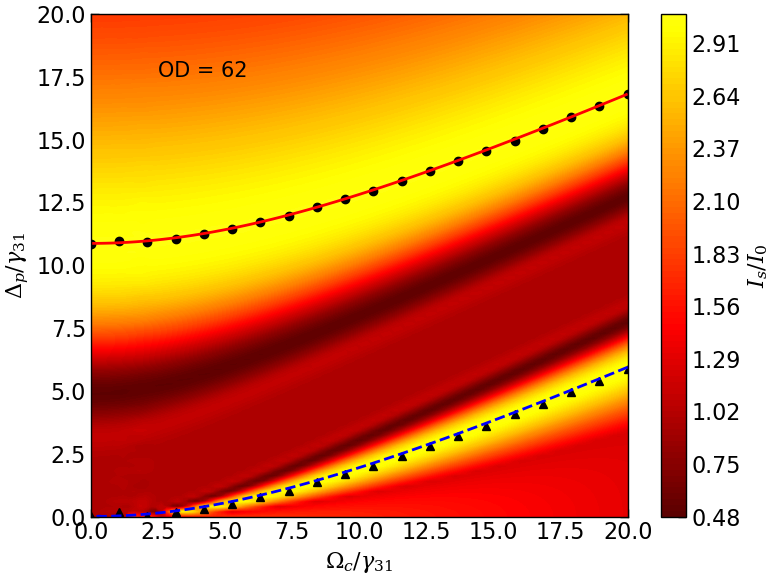

In [25]:
fig, ax = plt.subplots(1, 1, dpi=100)
ax.set_ylim(0, 20)

# Plot numerical data points
# marker-line-color
ax.plot(OmegaCArray/gamma31, 
        SpecWidthMaxArray/gamma31, 
        "ok", 
        label="Data (Type 1)")
ax.plot(OmegaCArray/gamma31, 
        SpecWidthNMaxArray/gamma31, 
        "^k", 
        label="Data (Type 2)")
# ax.plot(OmegaCArrayNorm, SpecWidthAltMaxArray1/gamma31, "*k", label = "Data (Alt Peak 1)")
# ax.plot(OmegaCArrayNorm, SpecWidthAltMaxArray2/gamma31, "sk", label = "Data (Alt Peak 2)")

# plot quadratic curve-fitting
# ax.plot(OmegaCArrayNorm, curve_fit1/gamma31, "-g", label = "Quadratic Curve-Fit (Type 1)")
# ax.plot(OmegaCArrayNorm, curve_fit2/gamma31, "-y", label = "Quadratic Curve-Fit (Type 2)")
# ax.plot(OmegaCArrayNorm, curve_fit3, "-g", label = "Quartic Curve-Fit (Alt PEak 1)")
# ax.plot(OmegaCArrayNorm, curve_fit4, "-m", label = "Quartic Curve-Fit (Alt Peak 2)")

# plot approximated, no additional phase shift term
# ax.plot(OmegaCArrayNorm, approxNoPhase1, "-c", label = "Approximated, Uncorrected (Type 1)")
# ax.plot(OmegaCArrayNorm, approxNoPhase2, "-y", label = "Approximated, Uncorrected (Type 2)")

# plot approximated, additional phase shift term
# ax.plot(OmegaCArrayNorm, approxPhase1, "-c", label = "Approximated, Corrected (Type 1)")
# ax.plot(OmegaCArrayNorm, approxPhase2, "-y", label = "Approximated, Corrected (Type 2)")

# plot approximated, additional phase term (implicit)
# CS3 = ax.contour(X, Y, approxPhaseImplicit1, [0], colors = "cyan")
# CS4 = ax.contour(X, Y, approxPhaseImplicit2, [0], colors = "yellow")
# ax.clabel(CS3, inline=1, fontsize=10)
# ax.clabel(CS4, inline=1, fontsize=10)
# labels = ["Approximated, Corrected (Type 1)", "Approximated, Corrected (Type 2)"]
# CS3.collections[0].set_label(labels[0])
# CS4.collections[0].set_label(labels[1])

# plot exact, no additional phase shift term
# CS3 = ax.contour(X, Y, exactNoPhase1, [0], colors = "cyan")
# CS4 = ax.contour(X, Y, exactNoPhase2, [0], colors = "yellow")
# ax.clabel(CS3, inline=1, fontsize=10)
# ax.clabel(CS4, inline=1, fontsize=10)
# labels = ["Exact, Uncorrected (Type 1)", "Exact, Uncorrected (Type 2)"]
# CS3.collections[0].set_label(labels[0])
# CS4.collections[0].set_label(labels[1])
    
#plot exact, additional phase shift term
CS1 = ax.contour(X, 
                 Y, 
                 exactPhase1, 
                 [0], 
                 colors="red", 
                 linestyles="solid")
CS2 = ax.contour(X, 
                 Y, 
                 exactPhase2, 
                 [0], 
                 colors="blue", 
                 linestyles="dashed")
# ax.clabel(CS1, inline=1, fontsize=10)
# ax.clabel(CS2, inline=1, fontsize=10)
labels = ["Eq. (#) (Type 1)", "Eq. (#) (Type 2)"]
CS1.collections[0].set_label(labels[0])
CS2.collections[0].set_label(labels[1])

# level1 = CS1.collections[0]
# paths1 = level1.get_paths()
# del(paths[0])

# level2 = CS2.collections[0]
# paths2 = level2.get_paths()
# del(paths[3])

# for vertice in paths1[0].vertices:
#     if vertice[1] < 10:
#         None

ax.set_xlabel("$\Omega_{c}/\gamma_{31}$")
ax.set_ylabel("$\Delta_{p}/\gamma_{31}$")

ax.tick_params(axis="x")
ax.tick_params(axis="y")
ax.text(x=2.5, 
        y=17.5, 
        s='OD = '+str(OD), 
        rotation=0,
        fontsize=15)

# ax.legend(loc="upper left")
ax.grid(False)

cs = ax.contourf(OmegaCGrid, 
                 detuningGrid, 
                 IsArray, 
                 cmap="hot", 
                 vmin=0, 
                 vmax=4, 
                 levels=100)
                 
colBar = fig.colorbar(cs)
colBar.set_label(label="$I_{s}/I_{0}$")                
colBar.ax.tick_params()

plt.tight_layout()
plt.show()

# $\Delta_p$ vs $OD$ surface plot

## arrays

In [28]:
OmegaC = 4.2*gamma31
OmegaCNorm = OmegaC/gamma31

N1 = 100
detuningArray2 = np.linspace(0*gamma31, 30*gamma31, N1)
detuningArray2Norm = detuningArray2/gamma31
ODArray = np.linspace(1, 200, N1)

IsArray = np.zeros((N1, N1))

for index_m, m in enumerate(ODArray):

    for index_n, n in enumerate(detuningArray2):
        detuning = n
        OD = m
        It = generate_temporal(detuning, OmegaC, OD)
        Is = np.max(It[downIndex: downIndex+200])
        IsArray[index_n, index_m] = Is

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(), 
                         'Proper Arrays', 
                         'Delta_p vs OD', 
                         'Delta_p_vs_OD_Omega_c_4.2_Surface_Plot.pkl')
                         
with open(SAVE_PATH, 'wb') as f:
    pickle.dump(IsArray, f)

In [26]:
SAVE_PATH = os.path.join(os.getcwd(), 
                         'Proper Arrays', 
                         'Delta_p vs OD', 
                         'Delta_p_vs_OD_Omega_c_4.2_Surface_Plot.pkl')
                         
with open(SAVE_PATH, 'rb') as f:
    IsArray = pickle.load(f)

## plotting

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_8112\2217468490.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colBar = fig.colorbar(cs)


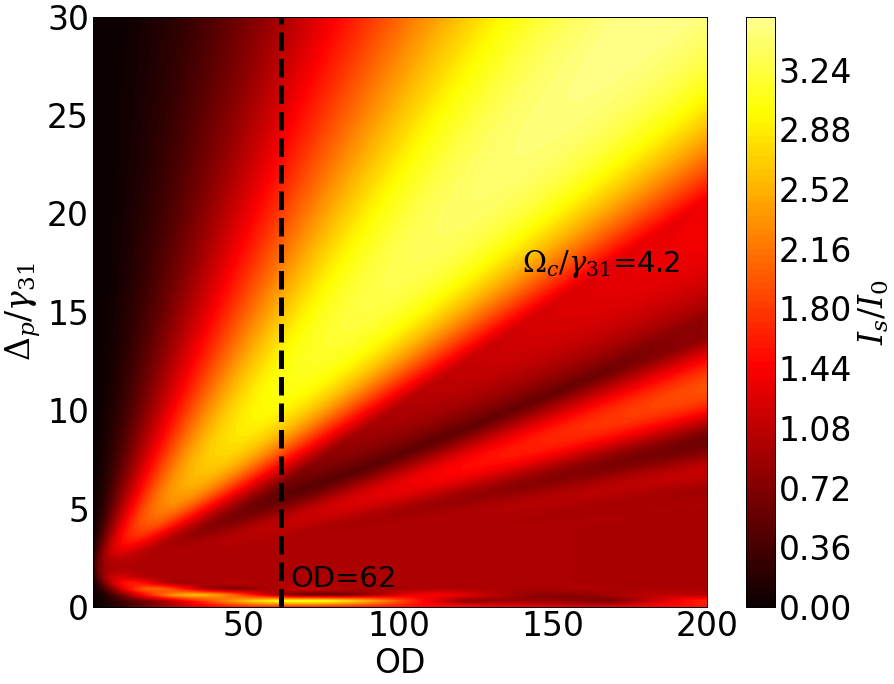

In [36]:
ODGrid, detuningGrid = np.meshgrid(ODArray, detuningArray2Norm)

# create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12.7, 9.7))

# create the plot itself
cs = ax.contourf(ODGrid, 
                 detuningGrid, 
                 IsArray, 
                 cmap="hot", 
                 vmin=0, 
                 vmax=4,
                 levels=100)

# generate colorbar indicator
colBar = fig.colorbar(cs)
colBar.set_label(label="$I_{s}/I_{0}$", size=33)
colBar.ax.tick_params(labelsize=33)

# axis labelling
ax.set_xlabel("OD", fontsize=33)
ax.set_ylabel("$\Delta_{p}/\gamma_{31}$", fontsize=33)

# change the axis ticks
ax.tick_params(axis="x", labelsize=33)
ax.tick_params(axis="y", labelsize=33)

# plot vertical line
ax.vlines(x=62,
          ymin=0,
          ymax=30,
          color="black", 
          linestyle="dashed", 
          linewidth=5)

# add annotations    
ax.text(x=65, 
        y=1, 
        s='OD=62', 
        rotation=0, 
        fontsize=29)
ax.text(x=140, 
        y=17, 
        s='$\Omega_{c}/\gamma_{31}$='+str(OmegaCNorm), 
        rotation=0,
        fontsize=29)

# line plot
# ax.plot(ODArray1, 
#         peak_detuning_type_1_array/gamma31, 
#         label='Type I',
#         linewidth=5)
# ax.plot(ODArray1, 
#         peak_detuning_type_2_array/gamma31, 
#         label='Type II', 
#         linewidth=5)
# ax.legend()
# ax.set_ylim(0, 30)

ax.grid(False)

fig.tight_layout()
plt.show()

# Exploring the data arrays

In [33]:
OmegaC = 4.2*gamma31

detuningArray3 = np.linspace(-100*gamma31, 100*gamma31, 1000)

detuningArray4 = np.linspace(-5*gamma31, 5*gamma31, 1000)

midPointIndex = round(len(detuningArray3)/2)
ODArray1 = np.linspace(1, 400, 20)

## finding the value of peak I_s where;
* $\Omega_c$ held constant at $4.2\gamma_{31}$
* Changing the OD for 30, 100, and 200

In [ ]:
local_maxima_indices = midPointIndex + find_peaks(IsArray[midPointIndex: ])[0]

if len(local_maxima_indices) == 1:    
    peak_I_s_type_1 = IsArray[local_maxima_indices[0]]
    print(f'With OD {OD}, Peak I_s value for type 1 is {peak_I_s_type_1}. No peak I_s value for type 2.')
elif len(local_maxima_indices) > 1:
    peak_I_s_type_1 = IsArray[local_maxima_indices[-1]]
    peak_I_s_type_2 = IsArray[local_maxima_indices[0]]
    print(f'With OD {OD}, Peak I_s value for type 1 is {peak_I_s_type_1}. Peak I_s value for type 2 is {peak_I_s_type_2}')
else:
    print("ERROR!")

In [ ]:
peak_I_s_type_1_array = np.array([])

for i, value in enumerate(ODArray1):
    OD = value
    IsArray = generate_spectrum(detuningArray3, OmegaC, OD)
    
    local_maxima_indices = midPointIndex + find_peaks(IsArray[midPointIndex: ], 1.0)[0]

    if len(local_maxima_indices) == 0:    
        peak_I_s_type_1 = 0
        # peak_I_s_type_2 = 0
        peak_I_s_type_1_array = np.append(peak_I_s_type_1_array, peak_I_s_type_1)
        # peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    elif len(local_maxima_indices) == 1:    
        peak_I_s_type_1 = IsArray[local_maxima_indices[-1]]
        # peak_I_s_type_2 = 0
        peak_I_s_type_1_array = np.append(peak_I_s_type_1_array, peak_I_s_type_1)
        # peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    elif len(local_maxima_indices) > 1:
        peak_I_s_type_1 = IsArray[local_maxima_indices[-1]]
        # peak_I_s_type_2 = IsArray[local_maxima_indices[0]]
        peak_I_s_type_1_array = np.append(peak_I_s_type_1_array, peak_I_s_type_1)
        # peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    else:
        print("ERROR!")

    # local_maxima_indices = find_peaks(IsArray[0: ], 1.0)[0]
    # num_peaks = len(local_maxima_indices)
    # index_choice = int(num_peaks/2)

    # if len(local_maxima_indices) == 0:    
    #     peak_I_s_type_1 = 0
    #     peak_I_s_type_2 = 0
    #     peak_I_s_type_1_array = np.append(peak_I_s_type_1_array, peak_I_s_type_1)
    #     peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    # elif len(local_maxima_indices) == 1:
    #     peak_I_s_type_1 = IsArray[local_maxima_indices[-1]]
    #     peak_I_s_type_2 = 0
    #     peak_I_s_type_1_array = np.append(peak_I_s_type_1_array, peak_I_s_type_1)
    #     peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    # elif len(local_maxima_indices) > 1:
    #     peak_I_s_type_1 = IsArray[local_maxima_indices[-1]]
    #     peak_I_s_type_2 = IsArray[local_maxima_indices[index_choice]]
    #     peak_I_s_type_1_array = np.append(peak_I_s_type_1_array, peak_I_s_type_1)
    #     peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    # else:
    #     print("ERROR!")

In [ ]:
peak_I_s_type_2_array = np.array([])

for i, value in enumerate(ODArray1):
    OD = value
    IsArray = generate_spectrum(detuningArray4, OmegaC, OD)

    local_maxima_indices = midPointIndex + find_peaks(IsArray[midPointIndex: ], 1.0)[0]

    if len(local_maxima_indices) == 0:    
        peak_I_s_type_2 = 0
        peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    elif len(local_maxima_indices) == 1:    
        peak_I_s_type_2 = IsArray[local_maxima_indices[0]]
        peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    elif len(local_maxima_indices) > 1:
        peak_I_s_type_2 = IsArray[local_maxima_indices[0]]
        peak_I_s_type_2_array = np.append(peak_I_s_type_2_array, peak_I_s_type_2)
    else:
        print("ERROR!")

In [ ]:
PATH = os.path.join(os.getcwd(), 
                    'I_s, Phase Shift, and Peak Detuning vs OD Data', 
                    'I_s vs OD', 
                    'peak_I_s_type_1_Omega_c_4.2_array_A.pkl')

with open(PATH, 'wb') as f:
    pickle.dump(peak_I_s_type_1_array, f)

In [ ]:
PATH = os.path.join(os.getcwd(), 
                    'I_s, Phase Shift, and Peak Detuning vs OD Data', 
                    'I_s vs OD', 
                    'peak_I_s_type_1_Omega_c_4.2_array_A.pkl')

with open(PATH, 'rb') as f:
    peak_I_s_type_1_array = pickle.load(f)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(ODArray1, peak_I_s_type_1_array, '-o', label='Type I')
ax.plot(ODArray1, peak_I_s_type_2_array, '-o', label='Type II')
ax.legend()
ax.set_title('Peak $I_{s}$ values for Type I and Type II')
ax.set_xlabel('OD')
ax.set_ylabel('Peak $I_{s}$ values')
ax.text(x=125, 
        y=1.7, 
        s='$\Omega_{c}/\gamma_{31}=$'+str(OmegaC/gamma31), 
        rotation=0, 
        fontsize=15)
# ax.set_xlim(20, 200)
plt.tight_layout()
plt.show()

## finding the value of phase shift where;
* $\Omega_c$ held constant at $4.2\gamma_{31}$
* Changing the OD for 30, 100, and 200

In [ ]:
local_maxima_indices = midPointIndex + find_peaks(IsArray[midPointIndex: ])[0]

if len(local_maxima_indices) == 1:    
    phase_shift_type_1 = phaseShift[local_maxima_indices[0]]/np.pi
    print(f'With OD {OD}, Phase shift value for type 1 is {phase_shift_type_1}. No phase shift value for type 2.')
elif len(local_maxima_indices) > 1:
    phase_shift_type_1 = phaseShift[local_maxima_indices[-1]]/np.pi
    phase_shift_type_2 = phaseShift[local_maxima_indices[0]]/np.pi
    print(f'With OD {OD}, Phase shift value for type 1 is {phase_shift_type_1}. Phase shift value for type 2 is {phase_shift_type_2}')
else:
    print("ERROR!")

In [ ]:
phase_shift_type_1_array = np.array([])
phase_shift_type_2_array = np.array([])

for i, value in enumerate(ODArray1):
    OD = value
    phase = np.real(k(detuningArray3))*L
    phaseShift = phase - k0*L
    IsArray = generate_spectrum(detuningArray3, OmegaC, OD)

    local_maxima_indices = midPointIndex + find_peaks(IsArray[midPointIndex: ], 2.0)[0]

    if len(local_maxima_indices) == 1:    
        phase_shift_type_1 = phaseShift[local_maxima_indices[-1]]
        phase_shift_type_1_array = np.append(phase_shift_type_1_array, phase_shift_type_1)
    elif len(local_maxima_indices) > 1:
        phase_shift_type_1 = phaseShift[local_maxima_indices[-1]]
        phase_shift_type_2 = phaseShift[local_maxima_indices[0]]
        phase_shift_type_1_array = np.append(phase_shift_type_1_array, phase_shift_type_1)
        phase_shift_type_2_array = np.append(phase_shift_type_2_array, phase_shift_type_2)
    else:
        print("ERROR!")

    # local_maxima_indices = find_peaks(IsArray[0: ], 2.0)[0]
    # num_peaks = len(local_maxima_indices)
    # index_choice = int(num_peaks/2)
    # phase_shift_type_1 = phaseShift[local_maxima_indices[-1]]
    # phase_shift_type_2 = phaseShift[local_maxima_indices[index_choice]]
    # phase_shift_type_1_array = np.append(phase_shift_type_1_array, phase_shift_type_1)
    # phase_shift_type_2_array = np.append(phase_shift_type_2_array, phase_shift_type_2)

In [ ]:
PATH = os.path.join(os.getcwd(), 
                    'I_s, Phase Shift, and Peak Detuning vs OD Data', 
                    'Phase Shift vs OD', 
                    'phase_shift_type_1_Omega_c_4.2_array.pkl')
                    
with open(PATH, 'wb') as f:
    pickle.dump(phase_shift_type_1_array, f)

In [ ]:
PATH = os.path.join(os.getcwd(), 
                    'I_s, Phase Shift, and Peak Detuning vs OD Data', 
                    'Phase Shift vs OD', 
                    'phase_shift_type_1_Omega_c_4.2_array.pkl')

with open(PATH, 'rb') as f:
    phase_shift_type_1_array = pickle.load(f)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(ODArray1, phase_shift_type_1_array/np.pi, label='Type I')
ax.plot(ODArray1, phase_shift_type_2_array/np.pi, label='Type II')
ax.legend()
ax.set_title('Phase Shift ($\phi_s$) Values for Type I and Type II')
ax.set_xlabel('OD')
ax.set_ylabel('Phase shift ($\phi_s$) values')
ax.text(x=125, 
        y=0, 
        s='$\Omega_{c}/\gamma_{31}=$'+str(OmegaC/gamma31), 
        rotation=0, 
        fontsize=15)

plt.tight_layout()
plt.show()

## finding the value of peak detuning where;
* $\Omega_c$ held constant at $4.2\gamma_{31}$
* Changing the OD for 30, 100, and 200 etc

In [ ]:
peak_detuning_type_1_array = np.array([])
peak_detuning_type_2_array = np.array([])

for i, value in enumerate(ODArray1):
    OD = value
    IsArray = generate_spectrum(detuningArray3, OmegaC, OD)

    local_maxima_indices = find_peaks(IsArray[0: ], 1.5)[0]
    num_peaks = len(local_maxima_indices)
    index_choice = int(num_peaks/2)

    if len(local_maxima_indices) == 0:    
        peak_detuning_type_1 = 0
        peak_detuning_type_2 = 0
        peak_detuning_type_1_array = np.append(peak_detuning_type_1_array, peak_detuning_type_1)
        peak_detuning_type_2_array = np.append(peak_detuning_type_2_array, peak_detuning_type_2)
    elif len(local_maxima_indices) == 1:
        peak_detuning_type_1 = detuningArray3[local_maxima_indices[-1]]
        peak_detuning_type_2 = 0
        peak_detuning_type_1_array = np.append(peak_detuning_type_1_array, peak_detuning_type_1)
        peak_detuning_type_2_array = np.append(peak_detuning_type_2_array, peak_detuning_type_2)
    elif len(local_maxima_indices) > 1:
        peak_detuning_type_1 = detuningArray3[local_maxima_indices[-1]]
        peak_detuning_type_2 = detuningArray3[local_maxima_indices[index_choice]]
        peak_detuning_type_1_array = np.append(peak_detuning_type_1_array, peak_detuning_type_1)
        peak_detuning_type_2_array = np.append(peak_detuning_type_2_array, peak_detuning_type_2)
    else:
        print("ERROR!")

    # local_maxima_indices = find_peaks(IsArray[0: ], 2.0)[0]
    # num_peaks = len(local_maxima_indices)
    # index_choice = int(num_peaks/2)
    # peak_detuning_type_1 = detuningArray3[local_maxima_indices[-1]]
    # peak_detuning_type_2 = detuningArray3[local_maxima_indices[index_choice]]
    # peak_detuning_type_1_array = np.append(peak_detuning_type_1_array, peak_detuning_type_1)
    # peak_detuning_type_2_array = np.append(peak_detuning_type_2_array, peak_detuning_type_2)

In [ ]:
PATH = os.path.join(os.getcwd(), 
                     'I_s, Phase Shift, and Peak Detuning vs OD Data', 
                     'Peak Detuning vs OD', 
                     'peak_detuning_type_1_Omega_c_4.2_A.pkl')
with open(PATH, 'wb') as f:
    pickle.dump(peak_detuning_type_1_array, f)

In [38]:
PATH = os.path.join(os.getcwd(), 
                     'I_s, Phase Shift, and Peak Detuning vs OD Data', 
                     'Peak Detuning vs OD', 
                     'peak_detuning_type_2_Omega_c_4.2_A.pkl')
with open(PATH, 'rb') as f:
    peak_detuning_type_2_array = pickle.load(f)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(ODArray1, peak_detuning_type_1_array/gamma31, label='Type I')
ax.plot(ODArray1, peak_detuning_type_2_array/gamma31, label='Type II')
ax.legend()
ax.set_title('Normalized Peak Detuning ($\Delta_{peak}/\gamma_{31}$) Values for Type I and Type II')
ax.set_xlabel('OD')
ax.set_ylabel('$\Delta_{peak}/\gamma_{31}$ values')
ax.text(x=0, 
        y=25, 
        s='$\Omega_{c}/\gamma_{31}=$'+str(OmegaC/gamma31), 
        rotation=0, 
        fontsize=15)

plt.tight_layout()
plt.show()